# Load the sentence pairs

In [7]:
configuration = "fi-100_ft-15000000_nb-30_ht-100000_di-uni_mx-1500_lg-no"
dataset_path = "datasets"
model_path = "trained_models/fine_tune_all_years_ded_coa_med_seq-128_old_fi-100_ft-15000000_nb-30_ht-100000_di-uni_mx-1500_lg-no/finetuned_model"

In [8]:
from utils import *
ip_documents = {}
ips1, ips2, sentence_pairs = get_next_sentence_pairs("ls24_live_dataset/day_2", ip_documents)

In [9]:
len(ips1), len(ips2), len(sentence_pairs)

(1397521, 1397521, 1397521)

In [10]:
sentence_dataset = SentencePairDataset(sentence_pairs, seq_length=128)
print(len(sentence_dataset))
# labels = infer_label(model_path, sentence_dataset, 1024)
embeddings = get_embeddings(model_path, sentence_dataset, batch_size=1024, resample=False, use_labels=False)

100%|██████████| 1397521/1397521 [00:00<00:00, 2017747.78it/s]


Coalescing


100%|██████████| 306894/306894 [00:12<00:00, 24549.20it/s]


Extracting tokens


100%|██████████| 306894/306894 [00:03<00:00, 99309.17it/s] 


1397521


100%|██████████| 1365/1365 [13:01<00:00,  1.75it/s]


In [11]:
import joblib
gmm = joblib.load("gmm_5_1.joblib")
clusters = gmm.predict(embeddings)

In [12]:
def get_host_host_cluster_counts(ips1, ips2, clusters):
    cluster_counts = {}
    for ip1, ip2, label in zip(ips1, ips2, clusters):
        host_host_identifier = ip1 + "_" + ip2
        if host_host_identifier not in cluster_counts:
            cluster_counts[host_host_identifier] = [0] * 5
        cluster_counts[host_host_identifier][label] += 1
    ip_pairs, counts =  zip(*cluster_counts.items())
    counts = np.array(counts)
    return ip_pairs, counts

ip_pairs, counts = get_host_host_cluster_counts(ips1, ips2, clusters)

In [13]:
def get_host_cluster_counts(ip_pairs, counts):
    host_counts = {}
    for key, counts in zip(ip_pairs, counts):
        ip1, ip2 = key.split("_")
        if ip1 not in host_counts:
            host_counts[ip1] = [0] * 5
        host_counts[ip1] = [a + b for a, b in zip(host_counts[ip1], counts)]
    hosts, host_counts = zip(*host_counts.items())
    host_counts = np.array(host_counts)
    return hosts, host_counts
host_pairs, host_counts = get_host_cluster_counts(ip_pairs, counts)

In [27]:
norm_host_counts = host_counts / host_counts.sum(axis=1, keepdims=True)

In [26]:
print([count for count, ip in zip(norm_host_counts, host_pairs) if ip in "84.17.53.155"])

[array([  86,   56,   17, 1725,  415])]


In [59]:
c2_hosts = [count for count, ip in zip(host_counts, host_pairs) if ip in ["14.0.0.46", "91.198.245.119", "15.230.174.69", "84.17.53.155"]]

In [60]:
c2_hosts = np.array(c2_hosts)

In [55]:
def get_most_similars(ip, norm_host_counts, host_pairs, n=5, distance='cosine'):
    # find index of ip
    idx = 0
    for i, host in enumerate(host_pairs):
        if host == ip:
            idx = i
            break
    
    if distance == 'euclidean':
        sims = np.linalg.norm(norm_host_counts - norm_host_counts[idx], axis=1)
    elif distance == 'cosine':
        sims = np.dot(norm_host_counts, norm_host_counts[idx])
    return [host for sim, host in sorted(zip(sims, host_pairs), reverse=True) if host != ip][:n]

In [57]:
print(get_most_similars("2606:4700:3036::6815:4b4d", host_counts, host_pairs, n=20, distance='euclidean'))

['155.207.1.90', '2a02:ec80:300:ed1a:0:0:2:b', '80.239.137.160', '79.125.55.116', '50.18.241.247', '47.88.198.68', '2606:4700:4400:0:0:0:6812:29fb', '2606:4700:10:0:0:0:ac43:d09', '2606:4700:0:0:0:0:6810:9095', '2603:1026:2405:1:0:0:0:f', '2600:9000:2375:7a00:12:352e:e540:93a1', '240e:ff:e020:94d:0:ff:b00f:b75', '2001:630:53:101:0:0:0:97', '18.165.144.149', '18.165.121.54', '108.156.22.111', '96.126.107.125', '47.237.28.39', '46.228.174.117', '44.237.151.236']


In [45]:
# find the most similar host to the c2 hosts in all host_counts
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(c2_hosts, host_counts)

# get top 20 most similar hosts (on average)
top_20 = np.argsort(similarities.mean(axis=0))[::-1][:100]
host_pairs = np.array(host_pairs)
top_20_hosts = host_pairs[top_20]

for idx in top_20:
    print(host_pairs[idx], similarities[:, idx].mean())

100.95.95.4 0.999936063131184
38.90.226.12 0.9999359098040563
91.228.167.137 0.9999357566610247
2a07:1181:95:95:0:0:0:4 0.9999354191069675
91.228.165.12 0.9999343632078451
212.45.194.115 0.9999338561436761
38.90.226.47 0.9999330526945036
38.90.226.46 0.9999329446498638
91.228.166.52 0.9999323360583509
179.51.205.128 0.9999321432162472
91.228.167.46 0.9999310658179784
100.101.0.206 0.999930217581416
91.228.165.44 0.9999300974362184
137.117.138.135 0.999929515618017
2a07:1182:101:0:0:0:0:89 0.999928943323014
91.228.165.40 0.9999287048124582
2a02:6ea0:d405:0:0:0:0:9993 0.9999282150607954
91.228.167.103 0.9999267258029075
38.90.226.11 0.9999245712352489
91.228.166.46 0.9999217634648853
2a07:1182:101:0:0:0:0:206 0.9999195576803911
2a07:1182:101:0:0:0:0:111 0.9999182552818409
38.90.226.13 0.9999179374692874
2a00:1450:4026:808:0:0:0:200e 0.9999165510716854
2a07:1182:101:0:0:0:0:46 0.9999164977526767
91.228.165.43 0.9999157556973788
20.199.120.85 0.9999153132101146
192.168.193.2 0.999913417125

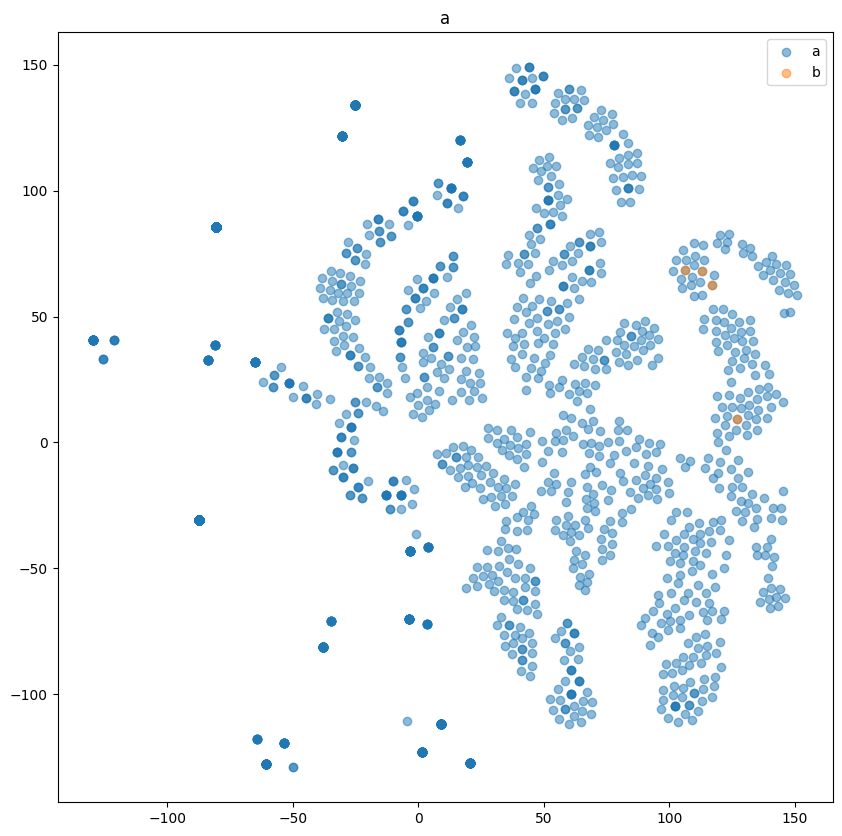

In [61]:
visualize_embeddings([host_counts, c2_hosts], ["a", "b"], "a", "tsne")

# Visualization

In [58]:
import pandas as pd
import plotly.express as px
from sklearn.manifold import TSNE

# Perform PCA on the embeddings
tsne = TSNE(n_components=2)

# Fit and transform the embeddings
tsne_embeddings = tsne.fit_transform(host_counts)

# Create a DataFrame for the embeddings
df = pd.DataFrame(tsne_embeddings, columns=["x", "y"])
df["label"] = [1 if ip in ["14.0.0.46", "91.198.245.119", "15.230.174.69", "84.17.53.155"] else 0 for ip in host_pairs]
df["ip_pair"] = host_pairs

# Create a scatter plot
fig = px.scatter(df, x="x", y="y", color="label", title="TSNE Phase 3", hover_data={"ip_pair": True})
fig.show()

# GMM Training

In [ ]:
# clustering using gmm
from sklearn.mixture import GaussianMixture
import joblib
from sklearn.model_selection import train_test_split

embedding_subsampled, _ = train_test_split(embeddings, train_size=0.1, random_state=42)
num_clusters = 10
gmm = GaussianMixture(n_components=num_clusters, random_state=42)
gmm.fit(embedding_subsampled),
joblib.dump(gmm, "gmm" + str(num_clusters) + ".joblib")

In [ ]:
emb_labels = gmm.predict(embeddings)
cluster_embeddings = []
for i in range(9, -1):
    cluster_embeddings.append([emb for j, emb in enumerate(embeddings) if emb_labels[j] == i])
visualize_embeddings(cluster_embeddings, [f"Cluster {i}" for i in range(9, -1)], "Clusters", "pca", alpha=0.1)

In [ ]:
rt_labels = gmm.predict(embeddings_ids)

In [ ]:
# plot histogram with five buckets
plt.hist(rt_labels, bins=10)
plt.show()

In [ ]:
c2_embeddings = [emb for i, emb in enumerate(embeddings) if emb_labels[i] == 1]
visualize_embeddings([embeddings, c2_embeddings], ["All", "Cluster 2"], "Cluster 2", "pca", alpha=0.1)

In [ ]:
c2_embeddings = [emb for i, emb in enumerate(embeddings) if emb_labels[i] == 6]
non_c2_embeddings = [emb for i, emb in enumerate(embeddings) if emb_labels[i] != 6]
visualize_embeddings([embeddings, c2_embeddings], ["All", "Cluster 1"], "Cluster 1", "pca", alpha=0.1)

In [ ]:
# store gmm model to disk
import joblib   
gmm = joblib.load("gmm10.joblib")

In [ ]:
num_clusters = 10

In [ ]:
len(ips1)

In [ ]:
def get_host_host_cluster_counts(ips1, ips2, full_embeddings, gmm):
    emb_labels = gmm.predict(full_embeddings)
    cluster_counts = {}
    for ip1, ip2, label in zip(ips1, ips2, emb_labels):
        host_host_identifier = ip1 + "_" + ip2
        if host_host_identifier not in cluster_counts:
            cluster_counts[host_host_identifier] = [0] * num_clusters
        cluster_counts[host_host_identifier][label] += 1
    ip_pairs, counts =  zip(*cluster_counts.items())
    counts = np.array(counts)
    return ip_pairs, counts

ip_pairs, counts = get_host_host_cluster_counts(ips1, ips2, full_embeddings, gmm)

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.manifold import TSNE

benign_counts_norm = benign_counts / np.sum(benign_counts, axis=1)[:, np.newaxis]
rt_counts_norm = rt_counts / np.sum(rt_counts, axis=1)[:, np.newaxis]
all_counts = np.concatenate([benign_counts_norm, rt_counts_norm])
all_labels = np.concatenate([np.zeros(len(benign_counts)), np.ones(len(rt_counts))])

# Perform PCA on the embeddings
pca = TSNE(n_components=2)

# Fit and transform the embeddings
pca_embeddings = pca.fit_transform(all_counts)

# Create a DataFrame for the embeddings
df = pd.DataFrame(pca_embeddings, columns=["x", "y"])
df["label"] = all_labels
df["ip_pair"] = np.concatenate([benign_pairs, rt_pairs])

# Create a scatter plot
fig = px.scatter(df, x="x", y="y", color="label", title="PCA of Hosts after Day 1", hover_data={"ip_pair": True})
fig.show()